In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import logging

from contextlib import contextmanager
from dataclasses import dataclass
from uplift_dgf import get_daily_visitors, get_daily_conversions, grid_configs
from typing import List
from tqdm.auto import tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set plot options
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [4]:
# Create random generator
random_seed = 1923
rng = np.random.default_rng(random_seed)

In [5]:
# Temporary log suppressing function for pymc sampling
@contextmanager
def suppress_logging(level):
    
    # Get logger & old level
    logger = logging.getLogger("pymc")
    old_level = logger.level

    # Change logger level, execute with statement (sampling functions)
    try:
        logger.setLevel(level)
        yield
    
    # Ensure logging is restored afterwards, even if try statement fails
    finally:
        logger.setLevel(old_level)

## Set true parameters

In [6]:
# Avg. visitors per day & its noise, as Poisson distributions
lam_visitors = 100
lam_visitors_noise = 5

In [27]:
# Conversion rates
conversion_control = 0.15
conversion_experiment = 0.20
true_effect_size = conversion_experiment - conversion_control
true_relative_uplift = (conversion_experiment / conversion_control) - 1

# Noise in conversion rates, as Beta distribution
# Mean = alpha / (alpha + beta)
conversion_noise_alpha = 3 
conversion_noise_beta = 100

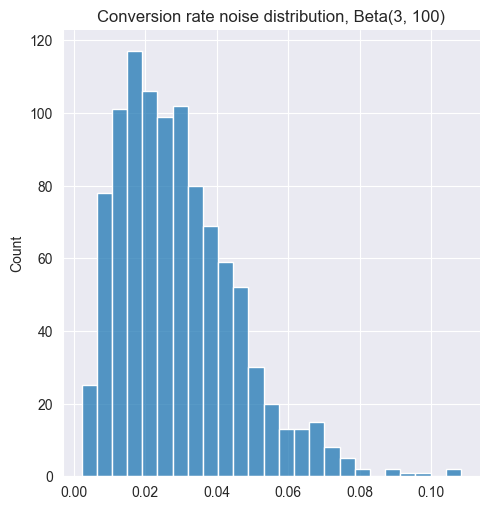

In [8]:
# Test conversion rate noise generation (sign will be randomly flipped)
sns.displot(
    np.random.beta(conversion_noise_alpha, conversion_noise_beta, 1000)
)
_ = plt.title(f"Conversion rate noise distribution, Beta({conversion_noise_alpha}, {conversion_noise_beta})")

## Define data & model classes

In [9]:
# Experiment data: Conversions out of visitors

@dataclass
class VariantData:
    visitors: int
    conversions: int

In [10]:
# Conversion rate priors as a Beta distribution

@dataclass
class ConversionPrior:
    alpha: float
    beta: float

In [42]:
class ConversionRateModel:

    def __init__(self, priors: List[ConversionPrior], data: List[VariantData], priors_label: str):

        # Set the conversion rate priors
        # 0: control, 1: experiment
        self.prior_control = priors[0]
        self.prior_experiment = priors[1]

        # Get experiment data
        # 0: control, 1: experiment
        self.visitors = [variant.visitors for variant in data]
        self.conversions = [variant.conversions for variant in data]

        self.priors_label = priors_label
        self.prior_predictive = None
        self.posterior_predictive = None
    
    def _create_model(self):

        # Define model
        with pm.Model() as model:

            # Conversion rate priors
            conversion_rate_control = pm.Beta(
                "conversion_rate_control",
                alpha = self.prior_control.alpha,
                beta = self.prior_control.beta
            )

            conversion_rate_experiment = pm.Beta(
                "conversion_rate_experiment",
                alpha = self.prior_experiment.alpha,
                beta = self.prior_experiment.beta
            )

            # Likelihoods
            likelihood_control = pm.Binomial(
                "outcome_control",
                n = self.visitors[0],
                p = conversion_rate_control,
                observed = self.conversions[0]
            )

            likelihood_experiment = pm.Binomial(
                "outcome_experiment",
                n = self.visitors[1],
                p = conversion_rate_experiment,
                observed = self.conversions[1]
            )

            # Relative uplift
            relative_uplift = pm.Deterministic(
                "relative_uplift",
                (conversion_rate_experiment / conversion_rate_control) - 1
            )
            
        return model
    
    def get_prior_predictive(self, **kwargs):

        # Sample prior predictive distribution
        with self._create_model():
            self.prior_predictive = pm.sample_prior_predictive(**kwargs)
    
    def get_posterior_predictive(self, **kwargs):

        # Sample posterior predictive distribution
        with self._create_model():
            self.posterior_predictive = pm.sample(**kwargs)
    
    def plot_prior_predictive(self, conversion_control, conversion_experiment, true_relative_uplift, kind = "kde",  **kwargs):
        
        if self.prior_predictive == None:
            self.get_prior_predictive(**kwargs)
        
        priors_label = self.priors_label

        # Plot conversion rate priors
        fig, ax = plt.subplots(2, sharex = True)

        # Control
        _ = az.plot_posterior(
            self.prior_predictive.prior["conversion_rate_control"],
            kind = kind,
            ax = ax[0]
            )
        _ = ax[0].axvline(conversion_control, color = "red")
        _ = ax[0].annotate(str(round(conversion_control, 2)), (conversion_control, 0.2))
        _ = ax[0].set_title(f"Control conversion rate, {priors_label} prior predictive")

        # Experiment
        _ = az.plot_posterior(
            self.prior_predictive.prior["conversion_rate_experiment"],
            kind = kind,
            ax = ax[1]
            )
        _ = ax[1].axvline(conversion_experiment, color = "red")
        _ = ax[1].annotate(str(round(conversion_experiment, 2)), (conversion_experiment, 0.2))
        _ = ax[1].set_title(f"Experiment conversion rate, {priors_label} prior predictive")

        plt.show()
        plt.close()

        # Plot outcome prior
        _ = az.plot_posterior(
            self.prior_predictive.prior["relative_uplift"],
            kind = kind
            )
        _ = plt.axvline(true_relative_uplift, color = "red")
        _ = plt.annotate(str(round(true_relative_uplift, 2)), (true_relative_uplift, 0.1))
        _ = plt.title(f"Relative uplift, {priors_label} prior predictive")

        plt.show()
        plt.close()
    
    def plot_posterior_predictive(self, conversion_control, conversion_experiment, true_relative_uplift, kind = "kde", **kwargs):
        
        if self.posterior_predictive == None:
            self.get_posterior_predictive(**kwargs)
        
        priors_label = self.priors_label

        # Plot conversion rate posteriors
        fig, ax = plt.subplots(2, sharex = True)

        # Control
        _ = az.plot_posterior(
            self.posterior_predictive.posterior["conversion_rate_control"],
            kind = kind,
            ax = ax[0]
            )
        _ = ax[0].axvline(conversion_control, color = "red")
        _ = ax[0].annotate(str(round(conversion_control, 2)), (conversion_control, 0.2))
        _ = ax[0].set_title(f"Control conversion rate, {priors_label} posterior predictive")

        # Experiment
        _ = az.plot_posterior(
            self.posterior_predictive.posterior["conversion_rate_experiment"],
            kind = kind,
            ax = ax[1]
            )
        _ = ax[1].axvline(conversion_experiment, color = "red")
        _ = ax[1].annotate(str(round(conversion_experiment, 2)), (conversion_experiment, 0.2))
        _ = ax[1].set_title(f"Experiment conversion rate, {priors_label} posterior predictive")

        plt.show()
        plt.close()

        # Plot outcome posterior
        _ = az.plot_posterior(
            self.posterior_predictive.posterior["relative_uplift"],
            kind = kind
            )
        _ = plt.axvline(true_relative_uplift, color = "red")
        _ = plt.annotate(str(round(true_relative_uplift, 2)), (true_relative_uplift, 0.1))
        _ = plt.title(f"Relative uplift, {priors_label} posterior predictive")

        plt.show()
        plt.close()

In [12]:
def generate_variant_data(days: int, conversion_rates: List[float]):

    # Assuming conversion_rates[0] is control
    variant_data_list = []
    
    for rate in conversion_rates:
        visitors = get_daily_visitors(days, lam_visitors, lam_visitors_noise, rng)
        conversions = get_daily_conversions(visitors, rate, conversion_noise_alpha, conversion_noise_beta, rng)
        variant_data = VariantData(sum(visitors), sum(conversions))
        variant_data_list.append(variant_data)
    
    return variant_data_list

## Preposterior analysis (EVSI estimation)

Sample size estimation logic:

- Define the EVSI (expected value of sample information) for a given sample size as the following loss function: 
    - `(true relative uplift - relative uplift prior mean) - (true relative uplift - relative uplift posterior mean)`
    - The "effect size loss reduction" yielded by the posterior estimate, relative to the prior estimate.
    - Could factor in other things like experiment cost here, but their units have to be the same.
    - Many options for designing this loss function. Has to reflect business goals. 
        - For example, determining if the effect is positive may be more important than determining its size accurately.
- Generate n. of experiment days to consider (which determines the sample size), and prior assumption sets.
- Determine minimum practical effect size.
    - Could do this for multiple effect sizes, but the procedure is already computationally expensive.
- For each configuration (targeted effect size, n. of days / sample size, prior assumption set),
    - Perform N trials, generating data from the minimum practical effect size & other assumptions, estimating N models.
    - Calculate the prior & posterior mean of the effect size for each trial,
    - Calculate EVSI as the "effect size loss reduction" for each trial,
    - Save the EVSI values & the posterior distributions from each trial.
- Average the EVSI values for each config.
- Plot the config variables against the resulting average EVSI values. Look for diminishing returns.
- Plot the effect size posterior distribution of each trial against the true practical effect size. Visually assess estimate accuracy & stability.
- Choose a sample size accordingly, along with practical considerations.

Can also determine arbitrary accept / reject criteria similar to frequentist hypothesis testing, and calculate Type II error rates & "power".
- Example:
    - Arbitrary p-value: 0.05
    - Probability density of the estimated posterior distribution above 0 -> Estimated probability of a positive relative uplift.
    - (1-p) >= 0.05: Conclude zero-negative relative uplift.
    - (1-p) < 0.05: Conclude positive relative uplift
    - Do this for every trial. Calculate (1 - type II error rate) to get "power".
    - Plot against the config variables & select sample size accordingly.

In [13]:
# Considered number of days
n_days = np.arange(1, 11, 3)

# Considered priors
weak_prior = [
    ConversionPrior(1, 5),
    ConversionPrior(1.5, 5.5)
]

medium_prior = [
    ConversionPrior(15, 85),
    ConversionPrior(25, 100)
]

strong_prior = [
    ConversionPrior(60, 340),
    ConversionPrior(100, 400)
]

priors = {
    "weak": weak_prior, 
    "medium": medium_prior, 
    "strong": strong_prior
}

# Dictionary of parameters
dict_parameters = {
    "n_days": n_days,
    "priors": priors.keys()
}

trials = 50
draws = 500
cores = 4

In [14]:
# Calculate "loss reduction" for each parameter combination
days_list = []
priors_list = []
losses_list = []
posterior_list = []

for j, config in tqdm(
    enumerate(grid_configs(dict_parameters)),
    desc = "configs",
    total = len(priors) * len(n_days)
    ):

    # Get parameters of config
    days = config["n_days"]
    prior_label = config["priors"]

    # Run trials for config
    loss_trials = []
    posterior_trials = []

    for i in tqdm(
        range(trials),
        desc = "trials",
        total = trials
        ):

        # Create model
        model = ConversionRateModel(
            priors = priors[prior_label],
            data = generate_variant_data(
                days = days, 
                conversion_rates = [conversion_control, conversion_experiment]
            ),
            priors_label = prior_label
        )

        # Disable logging for pymc
        # Function with context manager temporarily sets logging level to critical only,
        # executes sampling functions & reverts logging level to previous setting
        with suppress_logging(logging.CRITICAL):

            # Get prior predictive
            model.get_prior_predictive()
            
            # Get posterior predictive
            model.get_posterior_predictive(
                nuts_sampler = "blackjax", 
                draws = draws, 
                tune = draws, 
                chains = cores, 
                cores = cores, 
                progressbar = False
            )
        
        # Get prior & posterior mean effect sizes
        mu_prior = model.prior_predictive.prior.relative_uplift.mean()
        mu_posterior = model.posterior_predictive.posterior.relative_uplift.mean()

        # Calculate & record loss reduction
        # Loss from prior estimate - loss from posterior estimate
        loss_reduction = np.abs(true_relative_uplift - mu_prior) - np.abs(true_relative_uplift - mu_posterior)
        loss_trials.append(loss_reduction)

        # Save posterior predictive sample for trial
        posterior_trials.append(
            np.ravel(model.posterior_predictive.posterior.relative_uplift)
        )
    
    # Save parameters, trial average loss, list of posterior predictive samples for each config
    #effects_list.append(true_relative_uplift)
    days_list.append(days)
    priors_list.append(prior_label)
    losses_list.append(np.mean(loss_trials))
    posterior_list.append(posterior_trials)

configs:   0%|          | 0/12 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

trials:   0%|          | 0/50 [00:00<?, ?it/s]

1 effect size, 9 parameter configs (3 sample sizes, 3 priors), 100 trials per config: ~19 min per config MINIMUM, ~3hrs with default sampler MINIMUM

1 effect size, 15 parameter configs (5 sample sizes, 3 priors), 50 trials per config: ~3-20 min per config, ~45-150mins with blackjax sampler

Larger sample sizes greatly increase estimation time.

GPU sampler with JAX is also available, but only on Linux.

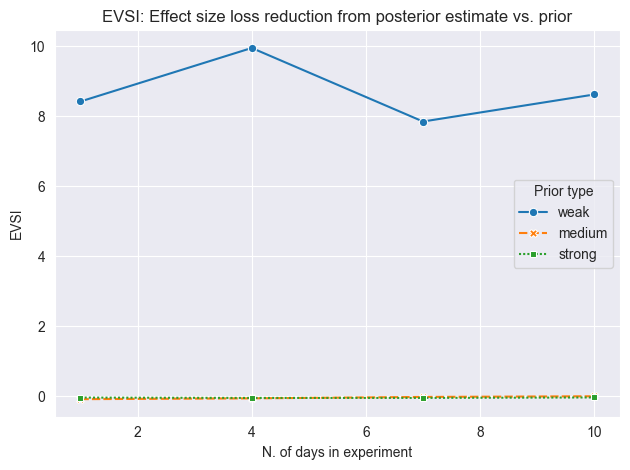

In [15]:
# Sample size vs. loss reduction plot
_ = sns.lineplot(
    x = days_list,
    y = losses_list,
    hue = priors_list,
    style = priors_list,
    markers = True
)
_ = plt.title("EVSI: Effect size loss reduction from posterior estimate vs. prior")
_ = plt.ylabel("EVSI")
_ = plt.xlabel("N. of days in experiment")
_ = plt.legend(title = "Prior type")

In [17]:
losses_list

[8.422671547883377,
 -0.08892265179350738,
 -0.04367930033665217,
 9.952973373904566,
 -0.06593717147679519,
 -0.05346417190645456,
 7.8499213979774565,
 -0.025360431409362637,
 -0.052991165481612805,
 8.623195151812098,
 -0.0057940946446384325,
 -0.040083524629651555]

Looks like the medium & strong priors' mean effect estimates are so good, average EVSI of the posterior estimations is practically zero or negative, even with 1-day experiments.

EVSI doesn't seem to monotonically increase with n. of experiment days, but we tried few configurations, and few trials. This experiment probably needs to be ran more comprehensively for meaningful results.

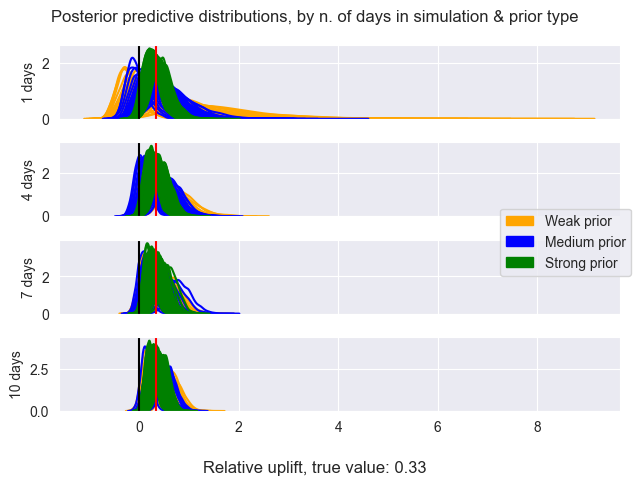

In [25]:
# Posterior predictive distributions plot, for each sample size, grouped by prior type
unique_days = set(days_list)

fig, ax = plt.subplots(len(unique_days), sharex = True)
fig.suptitle("Posterior predictive distributions, by n. of days in simulation & prior type")
fig.supxlabel(f"Relative uplift, true value: {round(true_relative_uplift, 2)}")
fig.legend(
    handles = [
        mpatches.Patch(color = "orange", label = "Weak prior"),
        mpatches.Patch(color = "blue", label = "Medium prior"),
        mpatches.Patch(color = "green", label = "Strong prior")
    ],
    loc = "right"
)

for n_days in unique_days:

    ax_idx = sorted(list(unique_days)).index(n_days)

    trials_array = np.reshape(
        np.array(posterior_list)[np.array(days_list) == n_days],
        (len(priors) * trials, (draws * cores))
    )

    colors = ["orange"] * trials + ["blue"] * trials + ["green"] * trials

    for i in range(0, trials_array.shape[0]):
        sns.kdeplot(
            trials_array[i, :],
            color = colors[i],
            ax = ax[ax_idx],
        )
    
    ax[ax_idx].set_ylabel(f"{n_days} days")
    ax[ax_idx].axvline(true_relative_uplift, color = "red")
    ax[ax_idx].axvline(0, color = "black")

Even with a 1-day experiment, a strong prior yields a pretty decent posterior predictive distribution.
- Weak & medium priors result in broad & unrealistic posterior distributions with 1-day experiments. But the average estimated effect still seems to be decent for the medium prior, hence the near-zero EVSI.

With more days, the priors' effectiveness converges, but some difference remains.

Odd posterior distributions for some medium prior, 7-day trials. Probably because the data is noisy.

Smallest n. of days that yield reasonable results, by prior:

- Weak: 4
- Medium: 4
- Strong: 1

Doing this experiment with more n. of days could result in a more sensitive estimate, we could find that  the medium prior also does well with 3, 2 days for example.

Let's see what happens with 3 days of experiments, & varying effect sizes.

In [26]:
optimal_days = 3

## Inference

In [43]:
def inference(model_priors: List[ConversionPrior], conversion_rates: List[float], experiment_days: int, priors_label: str):

    # Create model
    model = ConversionRateModel(
        priors = model_priors,
        data = generate_variant_data(
            days = experiment_days, 
            conversion_rates = conversion_rates
        ),
        priors_label = priors_label
    )

    # Calculate true relative uplift
    true_relative_uplift = (conversion_rates[-1] / conversion_rates[0]) - 1
    
    # Prior predictive check
    model.plot_prior_predictive(conversion_rates[0], conversion_rates[-1], true_relative_uplift)

    # Posterior estimation
    model.plot_posterior_predictive(conversion_rates[0], conversion_rates[-1], true_relative_uplift)

### Effect size < targeted practical effect size

Reduce the conversion rate difference by its half.

In [44]:
effect_size_small = [conversion_control, (conversion_experiment - (true_effect_size / 2))]

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


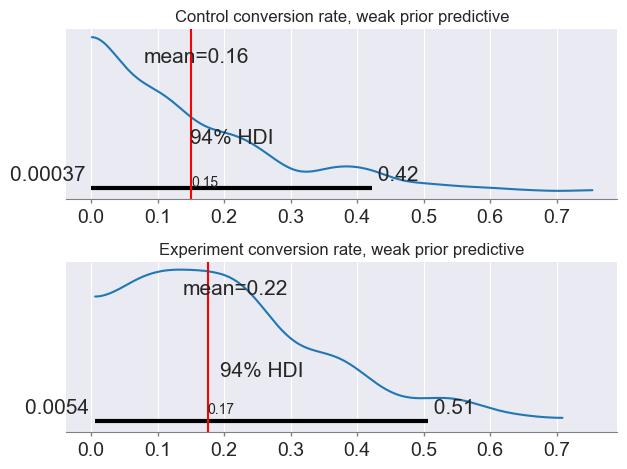

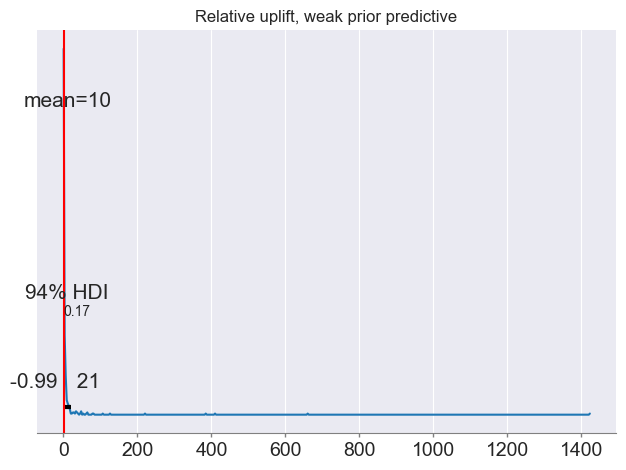

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


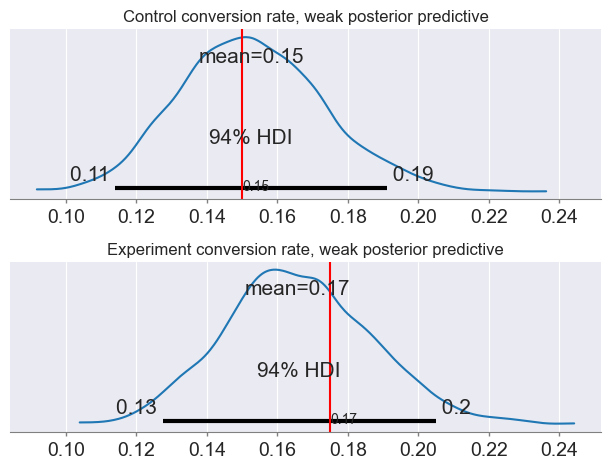

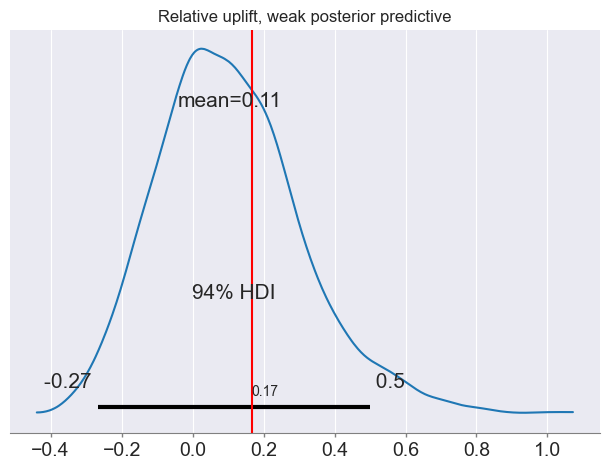

In [45]:
# Weak prior
inference(
    weak_prior,
    effect_size_small,
    optimal_days,
    "weak"
)


Weak prior still gets close to the small effect size on average, but the HDI is quite wide around 0.

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


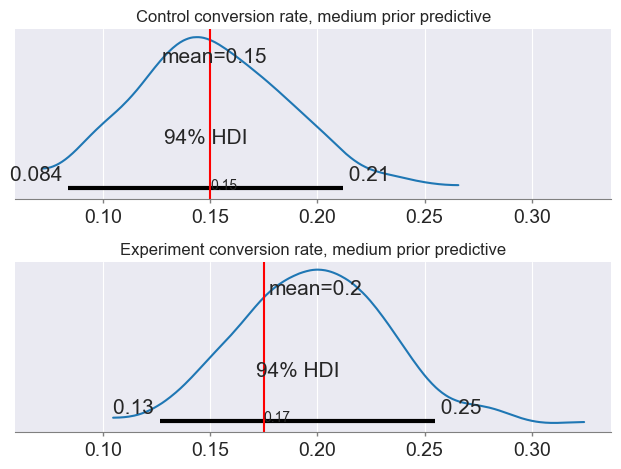

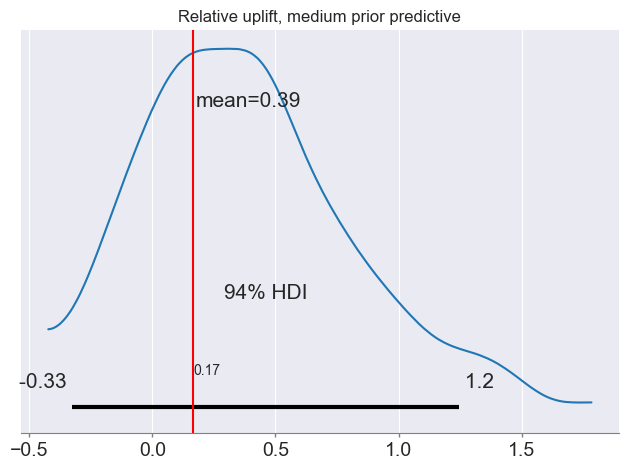

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


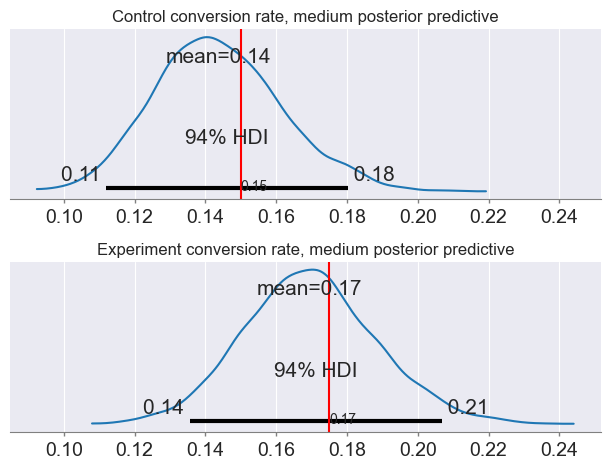

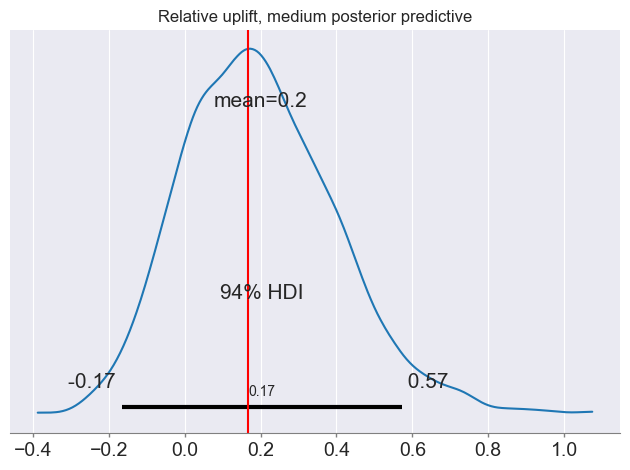

In [46]:
# Medium prior
inference(
    medium_prior,
    effect_size_small,
    optimal_days,
    "medium"
)

Medium prior gets very close to small effect size on average, HDI not too wide but probably could be considered risky for a decision.

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


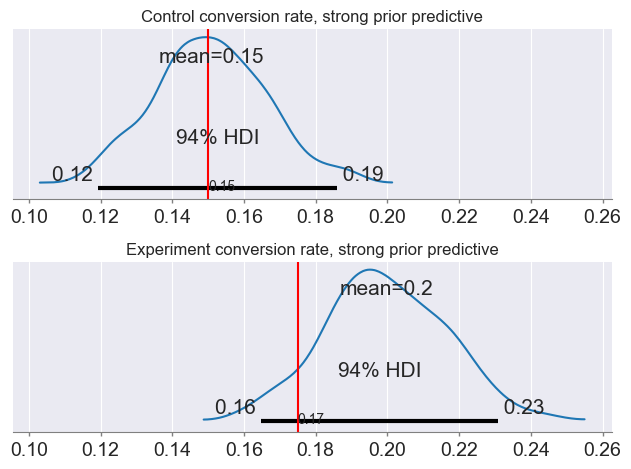

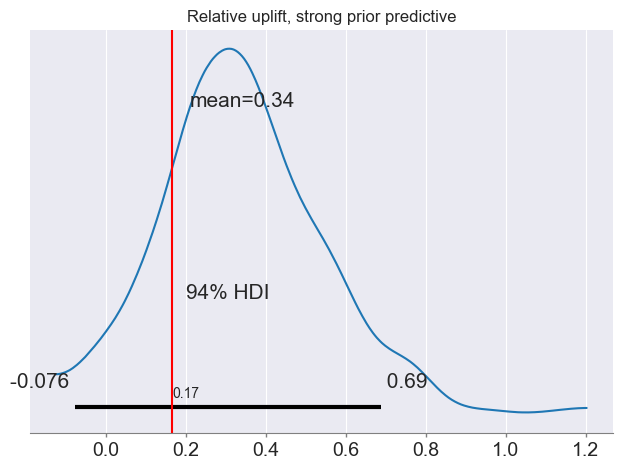

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


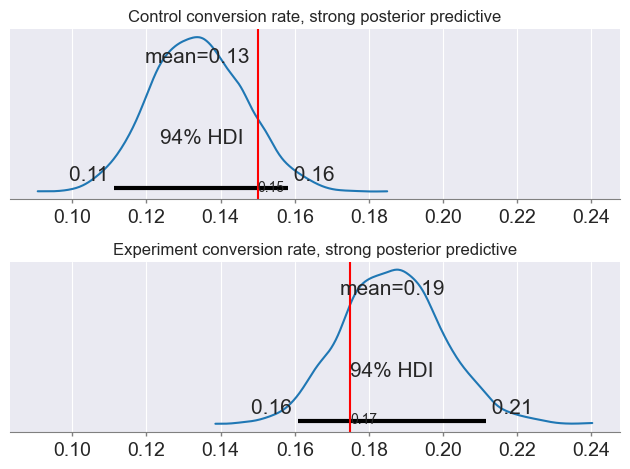

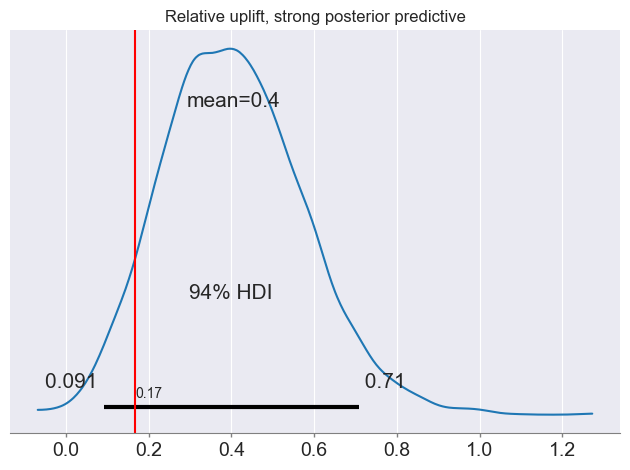

In [47]:
# Strong prior
inference(
    strong_prior,
    effect_size_small,
    optimal_days,
    "strong"
)

Strong prior overshoots the small effect size on average, because it is strongly tuned to the "true" effect size & experiment conversion rate (0.33, 0.2).

Still returns the most practically useful HDI that correctly excludes 0.

### Effect size > targeted practical effect size

Increase the conversion rate difference by its half.

In [48]:
effect_size_large = [conversion_control, (conversion_experiment + (true_effect_size / 2))]

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


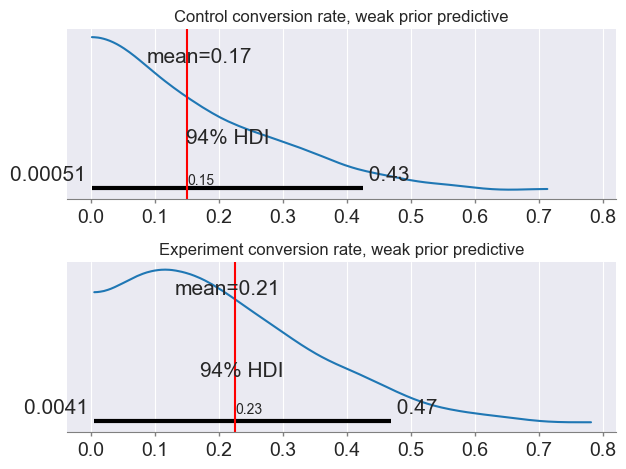

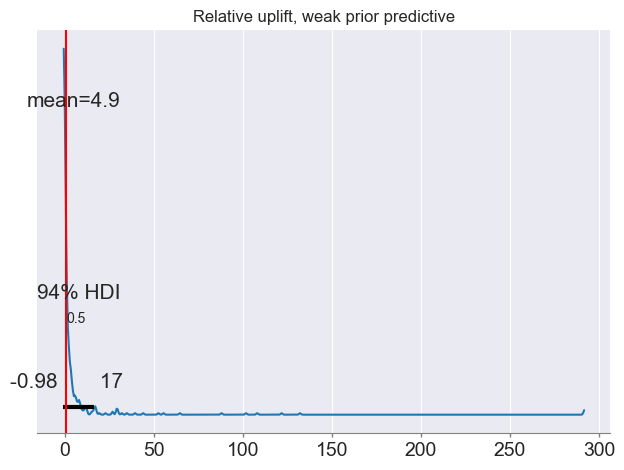

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


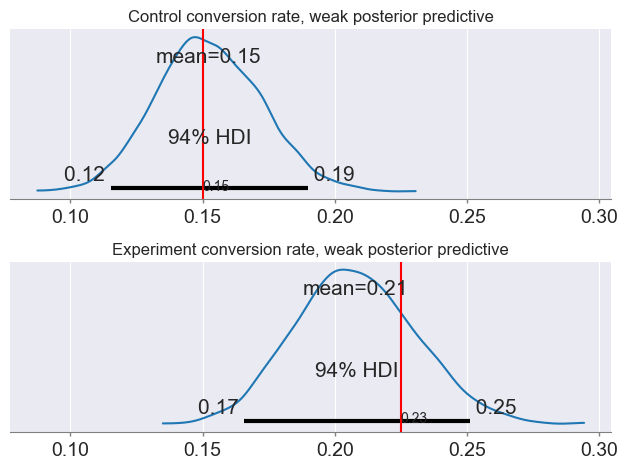

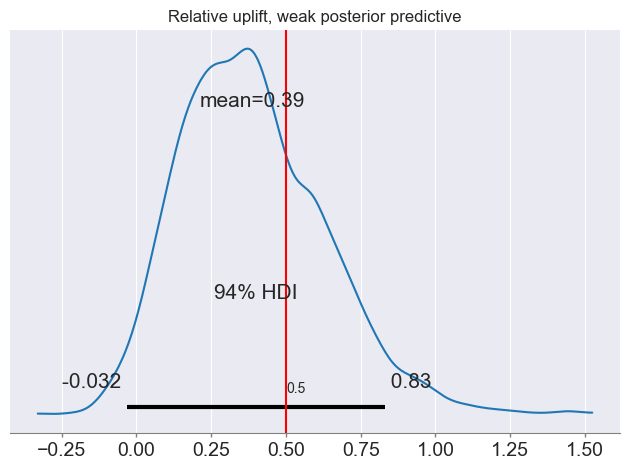

In [49]:
# Weak prior
inference(
    weak_prior,
    effect_size_large,
    optimal_days,
    "weak"
)


Weak prior gets close to the large effect size on average. HDI wide but barely contains zero.

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


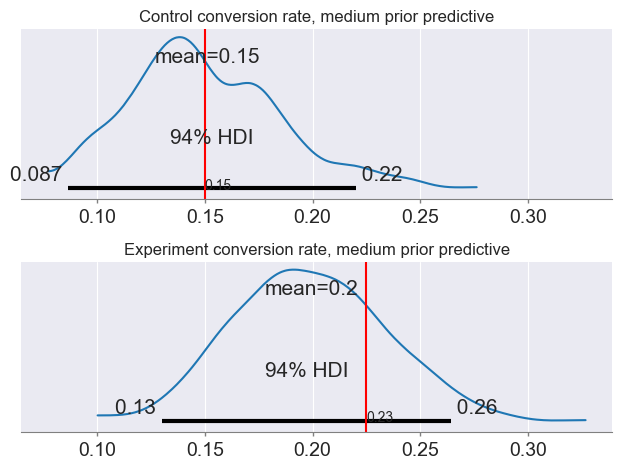

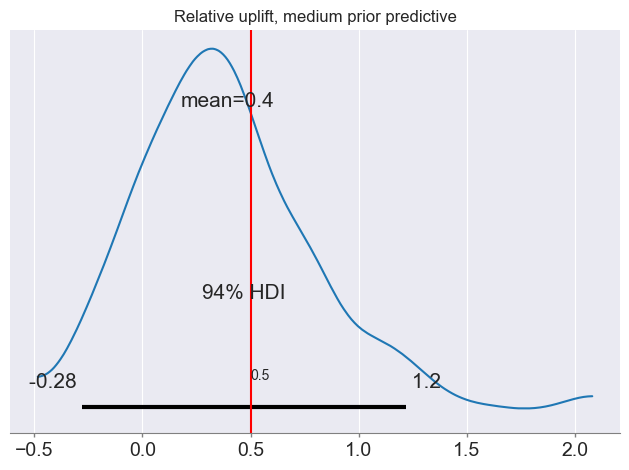

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.


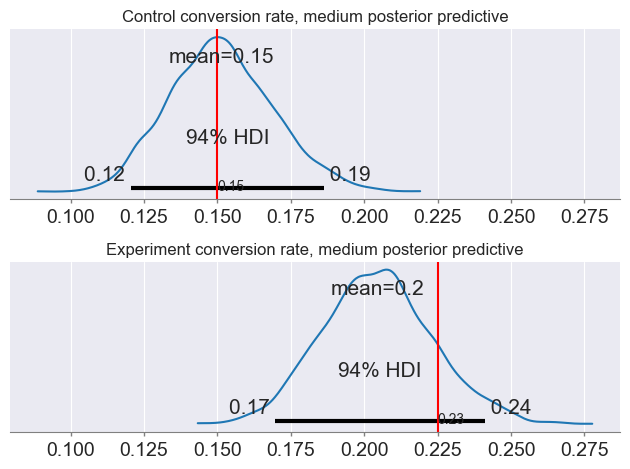

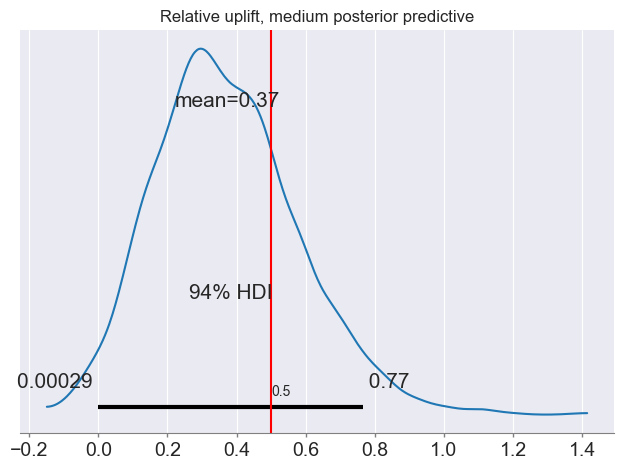

In [50]:
# Medium prior
inference(
    medium_prior,
    effect_size_large,
    optimal_days,
    "medium"
)

Medium prior gets close to large effect size on average, not as close as the weak prior, because it is more tuned to the true effect size.

HDI narrower & doesn't contain 0, but barely.

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


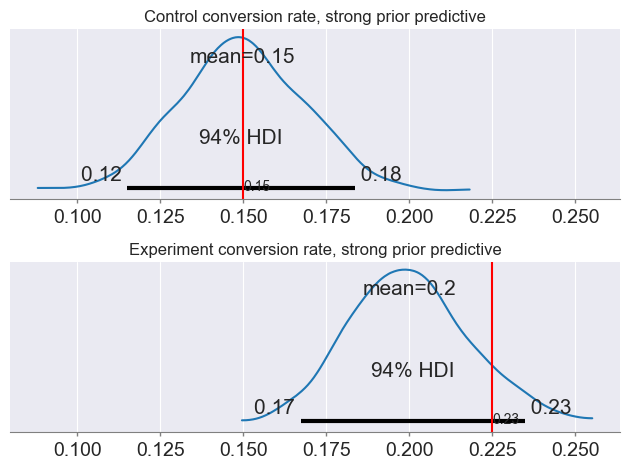

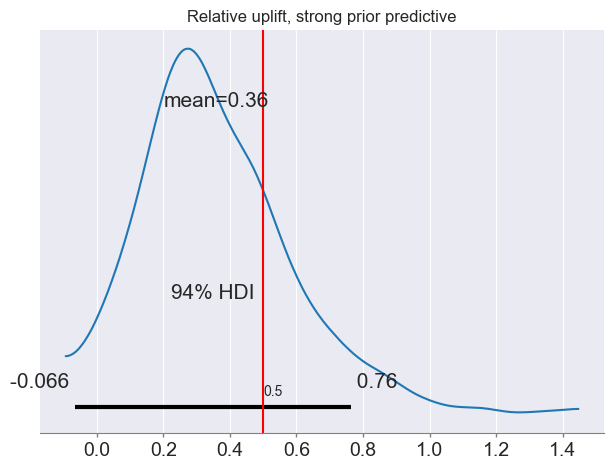

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


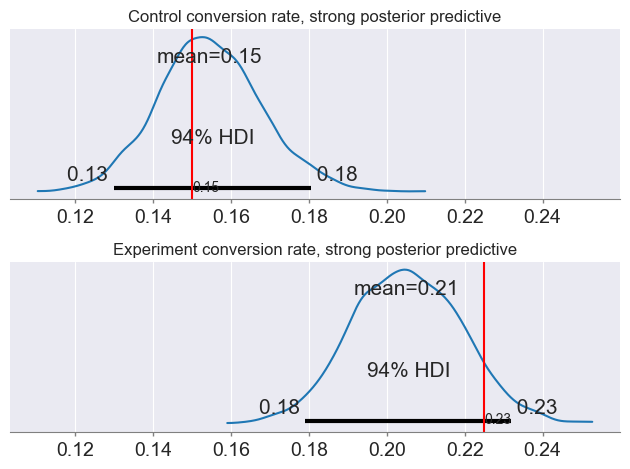

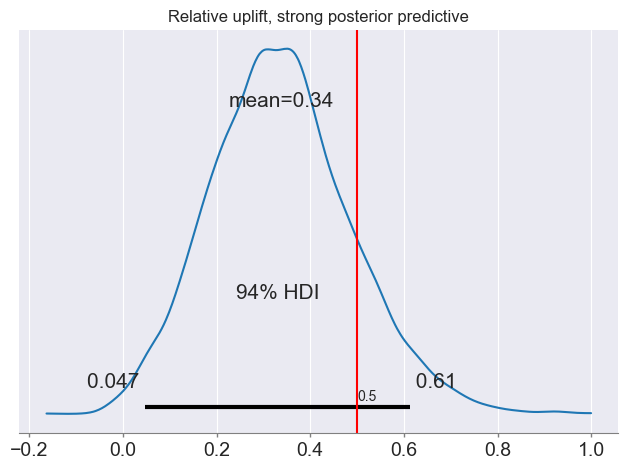

In [51]:
# Strong prior
inference(
    strong_prior,
    effect_size_large,
    optimal_days,
    "strong"
)

Strong prior farthest off from large effect size on average, due to being strongly tuned to true effect size.

Still yields the narrowest HDI that doesn't contain 0.

## Lessons learned

Prior choice is very nuanced, and a "strong" or "weak" prior is not necessarily better:

- A "weak" prior can yield a more accurate average effect size estimation, compared to a "strong" prior tuned to the wrong average.
- A "strong" prior can still yield a narrower HDI that correctly excludes 0, even if it's tuned to the wrong average & its average effect estimate is worse than a "weak" prior.
- The smaller the effect size, the harder it is to estimate a reliable HDI. However, if the prior average is not too far off, the average effect estimate can still turn out well.
    - An accurately narrow HDI is probably more important in most cases though: We don't necessarily need to know if the relative uplift will be 20% or 30%, if we are pretty sure it will be positive & practically significant.

A sample size choice based on EVSI / custom loss function probably needs a lot of configurations & trials to yield a meaningful conclusion. Or the loss function needs to be designed better.

Probably much easier to decide visually based on the posterior distributions of trials, or calculate "power" from them based on a hypothesis test rule.